<center><a href="https://www.nvidia.com/en-us/training/"><img src="https://dli-lms.s3.amazonaws.com/assets/general/DLI_Header_White.png" width="400" height="186" /></a></center>

<br>

# <font color="#76b900" style="text-align:center;">**Notebook 6.4:** Semantic Guardrailing</font>

<br>

This notebook is a direct continuation of the material in **Notebook 6: Embedding Models and Semantic Reasoning**. However, due to its length and deviation from the main topic, it has been sectioned off into its own notebook.

<br>

### **Environment Setup:**

In [1]:
## Necessary for Colab, not necessary for course environment
# %pip install -qq langchain langchain-nvidia-ai-endpoints gradio

# import os
# os.environ["NVIDIA_API_KEY"] = "nvapi-..."

## If you encounter a typing-extensions issue, restart your runtime and try again
# from langchain_nvidia_ai_endpoints import ChatNVIDIA
# ChatNVIDIA.get_available_models()

from functools import partial
from rich.console import Console
from rich.style import Style
from rich.theme import Theme

console = Console()
base_style = Style(color="#76B900", bold=True)
pprint = partial(console.print, style=base_style)

In [2]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA, NVIDIAEmbeddings

# NVIDIAEmbeddings.get_available_models()
embedder = NVIDIAEmbeddings(model="nvidia/nv-embed-v1")

# ChatNVIDIA.get_available_models()
instruct_llm = ChatNVIDIA(model="mistralai/mixtral-8x22b-instruct-v0.1")

# NVIDIAEmbeddings.get_available_models()

----

<br>

## **Part 4: [Advanced Exercise]** Embeddings For Semantic Guardrails

In the next notebook, we will use higher-level utilities to take our embedding model and use it under the hood. Before then, there are several essential concepts that we can explore while the raw methods are still fresh!

Specifically, we can use it as a backbone for a critical component of productionalized models: **semantic guardrailing**. Specifically, we can use the embeddings to filter out messages that are unlikely to be useful (or are actively harmful) for our chatbot to answer!

<br>

### **Advantage Over Autoregression-Guided Filtering**

You may recall from the previous notebooks that we can use our LLMs to facilitate complex internal reasoning, so why not filter with that? Specifically, you may be jumping the idea of asking an LLM to judge the question and then branch using a `RunnableBranch.` In truth, you can definitely do that, but that system has some hard pros and cons that need further consideration:

> **Pros:** It is relatively quick and easy to prompt engineer your internal system to restrict the progression of dialog. You can even develop a routine that takes examples of good and bad questions and generates a single compact prompt that consistently returns "Good" or "Bad" finite states.
>
> **Cons:** Using autoregressive routing usually comes with a handful of latency or resource overhead that might not be acceptable. For example, you may want to integrate a semantic guardrail mechanism behind the scenes that both prevents harmful outputs and steers problematic inputs toward safe and predictable directions. Your autoregressive options are as follows:
> - **You can use a relatively small instruction-tuned model to function as a zero-shot classifier and hope for its performance to stay consistent** To facilitate this, you may also need to convert the inputs into a canonical (standard) form for which your model performs optimally.
> - **You can also fine-tune a small autoregressive LLM to work well for your task.** You'll have to do some synthetic data curation and might need to spend some extra computing budget for a one-time fine-tuning cost, but this should at least allow a smaller model to mimic the performance of a larger prompt-engineered model by default.

While these options are fine, this specific use case can be nicely approached with a decent embedding model, some data curation, and a recollection of fundamental deep learning ideas.

**Specifically, we can use an embedding model as a language backbone and can then train a classifier on top of it to predict a probability**. We will explore this idea and address new challenges as they come up.

<br>

#### **Task 1: Generate Synthetic Data.**

To start making a semantic guardrail, we obviously need to start out with some goals.

- **Assumption:** Let's say we'd like to make an NVIDIA Chatbot that should primarily respond to discuss technology and company-relevant details! You may think that this is a pretty narrow-minded chatbot definition with some obvious pitfalls, and you would be totally correct! Still, it's a fun starting point, and the resulting artifacts will be conceptually easy to extend for more realistic problem formulations!

- **Plan of Action**: To help identify what kinds of entries we're dealing with, it's a good idea to generate some representative inputs to define what are *good* and *poor* inputs to respond to. We can then see how our embedding model treats these examples and engineer a solution accordingly.

Unfortunately, we don't have any real data with us, so it looks like synthetic generation will have to do! As an exercise, generate some representative good and poor examples that you can use for your downstream guardrail fitting.


In [3]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import ChatMessage
from operator import itemgetter

## Useful method for mistral, which is currently tuned to output numbered outputs
def EnumParser(*idxs):
    '''Method that pulls out values from a mistral model that outputs numbered entries'''
    idxs = idxs or [slice(0, None, 1)]
    entry_parser = lambda v: v if ('. ' not in v) else v[v.index('. ')+2:]
    out_lambda = lambda x: [entry_parser(v).strip() for v in x.split("\n")]
    return StrOutputParser() | RunnableLambda(lambda x: itemgetter(*idxs)(out_lambda(x)))

instruct_llm = ChatNVIDIA(model="mistralai/mixtral-8x7b-instruct-v0.1") | EnumParser()

from langchain_nvidia_ai_endpoints import ChatNVIDIA, NVIDIAEmbeddings

gen_prompt = {'input' : lambda x:x} | ChatPromptTemplate.from_template(
    "Please generate 20 representative conversations that would be {input}."
    " Make sure all of the questions are very different in phrasing and content."
    " Do not respond to the questions; just list them. Make sure all of your outputs are numbered."
    " Example Response: 1. <question>\n2. <question>\n3. <question>\n..."
)

## Some that directly reference NVIDIA
responses_1 = (gen_prompt | instruct_llm).invoke(
    " reasonable for an NVIDIA document chatbot to be able to answer."
    " Vary the context to technology, research, deep learning, language modeling, gaming, etc."
)
print("Reasonable NVIDIA Responses:", *responses_1, "", sep="\n")

## And some that do not
responses_2 = (gen_prompt | instruct_llm).invoke(
    " be reasonable for a tech document chatbot to be able to answer. Make sure to vary"
    " the context to technology, research, gaming, language modeling, graphics, etc."
)
print("Reasonable non-NVIDIA Responses:", *responses_2, "", sep="\n")

## Feel free to try your own generations instead
responses_3 = (gen_prompt | instruct_llm).invoke(
    "unreasonable for an NVIDIA document chatbot to answer,"
    " as it is irrelevant and will not be useful to answer (though not inherently harmful)."
)
print("Irrelevant Responses:", *responses_3, "", sep="\n")

responses_4 = (gen_prompt | instruct_llm).invoke(
    "unreasonable for a chatbot (NVIDIA's, AMD's, Intels, or Generally) to answer,"
    " as an automated response will either be overly insensitive or offensive."
)
print("Harmful non-NVIDIA", *responses_4, "", sep="\n")

## Feel free to try your own generations instead

good_responses = responses_1 + responses_2
poor_responses = responses_3 + responses_4

Reasonable NVIDIA Responses:
"Can you tell me about the latest advancements in deep learning technology at NVIDIA?"
"What kind of research is NVIDIA currently conducting in the field of autonomous vehicles?"
"How does NVIDIA's language modeling technology compare to other companies in the industry?"
"Can you provide an overview of NVIDIA's role in the development of artificial intelligence?"
"What are some examples of how NVIDIA's graphics technology is being used in the gaming industry?"
"Can you explain how NVIDIA's deep learning platforms are being used in healthcare?"
"What are the benefits of using NVIDIA's DGX systems for data science research?"
"Can you tell me about any partnerships or collaborations NVIDIA has with other tech companies?"
"How is NVIDIA's technology being used in the field of robotics and automation?"
"Can you explain the role of NVIDIA's GPUs in the development of virtual reality?"
"What are some of the real-world applications of NVIDIA's deep learning technol

<br>

### **Task 2: Generate More Embeddings (and faster)**

Once you're happy with the synthetic data, it's time to embed them all into semantic vectors. Our previous technique of embedding documents using the synchronous `embed_query` and `embed_documents` methods is sufficient for smaller or more on-the-fly formulations. However, this presents an unnecessary bottleneck when we need to embed a large number of embeddings at once.

In this section, we will use **asynchronous techniques** to allow multiple embedding operations to happen simultaneously! Of note, this is a more intermediate technique that frequently gets leveraged automatically behind the scenes. **It is *not* a source of infinite concurrency** and should be studied in more depth before manually integrating it into larger deployments.

<br>

#### **Timing Solutions**

The `%%time` utility does not work for asynchronous solutions in the notebook, so the following is a scope-based timing utility which should make our lives easier. Below, we define it and test out how long it takes to embed the first 10 documents:

In [4]:
import time
import numpy as np

class Timer():
    '''Useful timing utilities (%%time is great, but doesn't work for async)'''
    def __enter__(self):
      self.start = time.perf_counter()

    def __exit__(self, *args, **kwargs):
        elapsed = time.perf_counter() - self.start
        print("\033[1m" + f"Executed in {elapsed:0.2f} seconds." + "\033[0m")

with Timer():
    good_embeds = [embedder.embed_query(x) for x in good_responses[:10]]

print("Shape:", np.array(good_embeds).shape)

Executed in 3.75 seconds.
Shape: (10, 4096)


<br>

#### **Towards Asynchronous Embeddings**

Notice how this embedding query takes a lot of time to execute. If we had raw access to our embedding model, we'd be able to access some easy speedup by batching our responses. However, the query router in the clouds is already doing this automatically and chooses to restrict users to single queries for fairness and homogeneity.

In other words, it's not that the service can't embed faster, but rather that our code is waiting for every single embedding to happen *in series* for each `embed_query` command.

When we need to embed a lot of documents all at once, it's generally a better idea to lodge all of the requests at once *asynchronously* and wait for the results to come in. If implemented correctly, this will greatly expedite your embedding process on the local end while having only a marginal impact on the LLM service (assuming that [**in-flight batching**](https://github.com/NVIDIA/TensorRT-LLM/blob/b777bd64750abf30ca7eda48e8b6ba3c5174aafd/docs/source/advanced/gpt-attention.md?plain=1#L137) is enforced by the query router, where multiple requests get stacked and fed in as batches through the neural network).

We can test out the LangChain-standard `aembed_<...>` options to generate some **Coroutines**, which are processes intended for **concurrent** execution:


In [5]:
with Timer():
    good_embed_gens = [embedder.aembed_query(query) for query in good_responses[10:20]]
print(good_embed_gens[0])

## NOTE: When you define coroutines, you will want to either execute them or close them.
##  Destroying an open coroutine object by overriding will throw a warning.
for gen in good_embed_gens:
    gen.close()

Executed in 0.00 seconds.
<coroutine object Embeddings.aembed_query at 0x7fb7a62ecac0>


They can be awaited individually using the `await` keyword or executed concurrently using something similar to the [`asyncio.gather`](https://docs.python.org/3/library/asyncio-task.html#id8) routine. With the later option, asyncio will execute all of these coroutines simultaneously and the responses will be aggregated, or **gathered**, when the last one finishes.

In [6]:
import asyncio

with Timer():
    tasks = [embedder.aembed_query(query) for query in good_responses[10:20]]
    good_embeds2 = await asyncio.gather(*tasks)

print("Shape:", np.array(good_embeds2).shape)

Executed in 1.86 seconds.
Shape: (10, 4096)


Whereas the previous non-async version showed how long it took to embed all of these responses *in series*, this new time reflects how long the process took *concurrently*, roughly correlating with the longest single embedding request.

<br>

#### **Limiting Concurrency**

Though this system is significantly faster than our synchronous version, it's important to note that the concurrency can't be stacked infinitely! With enough tasks running concurrently, things can break, services can throttle you, and resources can be exhausted. In practice, it's a good idea to use some controlling structures to limit the maximum concurrency, for example using the asyncio **semaphore** structure (an async primitive to limit max concurrency):


In [7]:
import asyncio
from collections import abc
from typing import Callable
from functools import partial

async def embed_with_semaphore(
    text : str,
    embed_fn : Callable,
    semaphore : asyncio.Semaphore
) -> abc.Coroutine:
    async with semaphore:
        return await embed_fn(text)

## Making new embed method to limiting maximum concurrency
embed = partial(
    embed_with_semaphore,
    embed_fn = embedder.aembed_query,
    semaphore = asyncio.Semaphore(value=10)  ## <- feel free to play with value
)

## This is once again a coroutine constructor, so should take marginal time
tasks = [embed(query) for query in good_responses[20:30]]

with Timer():
    good_embeds_3 = await asyncio.gather(*tasks)

Executed in 2.04 seconds.


<br>

#### **[Exercise] Embed The Rest of the Responses**

Now that you've seen how to do this process, wrap up by embedding the rest of the documents using these new techniques. Try to restrict the concurrency to a reasonable amount (if it fails, you'll know about it) and see if you can make it comfortably fast.

In our tests in the system's current state, we found 10 to be a sweet spot after which our concurrency benefits started to taper off. Keep that in mind as you select your values.

In [8]:
####################################################################################
## BEGIN TODO

## Note, we found marginal benefit after value=10 in our tests...
with Timer():
    good_tasks = [embedder.aembed_query(query) for query in good_responses]
    poor_tasks = [embedder.aembed_query(query) for query in poor_responses]
    good_embeds = await asyncio.gather(*good_tasks)
    poor_embeds = await asyncio.gather(*poor_tasks)

print("Good Embeds Shape:", np.array(good_embeds).shape)
print("Poor Embeds Shape:", np.array(poor_embeds).shape)

## END TODO
####################################################################################

Executed in 13.48 seconds.
Good Embeds Shape: (40, 4096)
Poor Embeds Shape: (40, 4096)


### **Task 3: Confirming Semantic Density**

Our reason for generating these embeddings hinges on the assumption that they would be useful for semantic filtering. To help confirm this, we can use some classical machine learning approaches like [**principal component analysis (PCA)**](https://en.wikipedia.org/wiki/Principal_component_analysis) or [**t-distributed stochastic neighbor embedding (t-SNE)**](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) for dimensionality reduction. These techniques essentially transform high-dimensional data into lower-dimensional representations while trying to keep the important statistical properties intact. They're great for visualizing semantic clusters, so let's see what happens when we perform it on our embeddings:

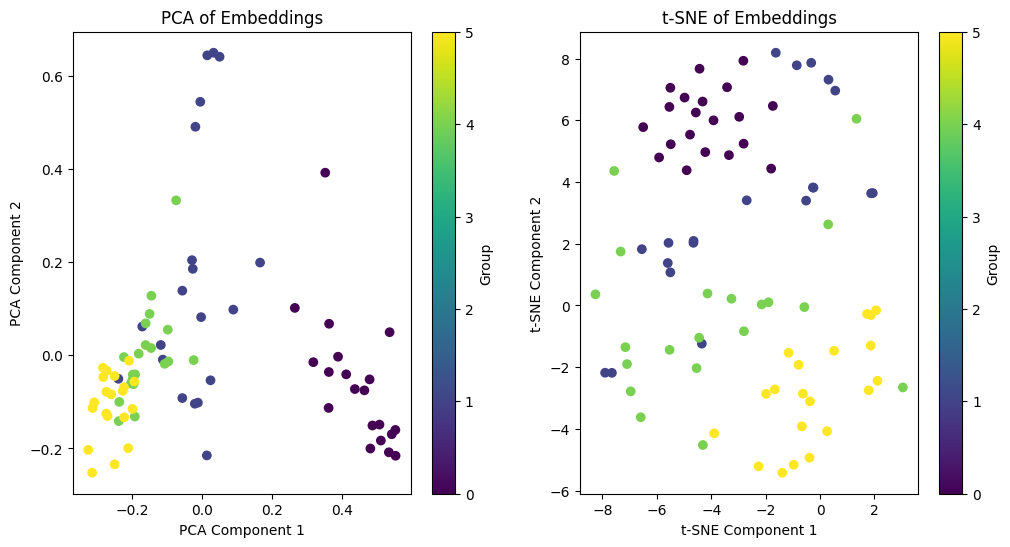

In [9]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

# Combine all groups into a single dataset
embeddings = np.vstack([good_embeds, poor_embeds])

# Labels for each point
labels = np.array([0]*20 + [1]*20 + [4]*20 + [5]*20)

# Perform PCA
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_tsne = tsne.fit_transform(embeddings)

# Plotting PCA
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=labels, cmap='viridis', label=labels)
plt.title("PCA of Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Group')

# Plotting t-SNE
plt.subplot(1, 2, 2)
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=labels, cmap='viridis', label=labels)
plt.title("t-SNE of Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(label='Group')

plt.show()

<br>

If everything went correctly, you should be seeing some pretty evident clustering of your responses. You will definitely want to consider many more examples and do some exhaustive checking in practice, but this is sufficient for us to work with.

<br>

### **Task 4:** Training Our Classifier

From these embeddings, we can train up a simple classifier that predicts whether an embedding is good or bad!

Despite our CPU-bound environment assumptions, a simple two-layer network is likely to be sufficient for this use case since we're leveraging a strong embedding model backbone. Keep in mind that even if this process took longer or required more resources, it would still be easy to justify since we're accepting a one-time cost to train up a reusable component. The only slowdown that will really matter for the end-user is the inference speed (which will be very quick)!

#### **Training a Deep Classifier**

If you have a complex decision boundary and are comfortable with deep learning, you may be inclined to make a classifier with a framework like [Keras](https://keras.io/keras_3/). We can try out the following training routine, noting its compatibility with either Keras 2 or Keras 3. If you are unfamiliar with this framework, we'd recommend checking out the respective guides:

- **[Keras 3.0 Functional API](https://keras.io/guides/functional_api/)**
- **[Keras 3.0 Sequential Model](https://keras.io/guides/sequential_model/)**

In [10]:
with Timer():
    print("Importing Keras for the first time")
    import keras
    from keras import layers

def train_model_neural_network(class0, class1):
    ## Classic deep learning training loop. If using this, train it to convergence
    model = keras.Sequential([
        layers.Dense(64, activation='tanh'),
        layers.Dense(1, activation='sigmoid'),
    ])
    ## Since this network is so shallow and the embedding backbone is "kept frozen"
    ##  a high learning rate should not overfit and will actually converge very quickly.
    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate = 1),
        loss = [keras.losses.BinaryCrossentropy(from_logits=False)],
        metrics = [keras.metrics.BinaryAccuracy()],
    )
    ## Since this uses stochastic gradient descent, we'll need to repeat this process

    reps_per_batch = 64*5  ## <- repeat the dataset, effectively increasing "epochs" without printing too much
    epochs = 2             ## <- one epoch should actually be sufficient; 2 to print out an updated training loss
    x = np.array((class0 + class1) * reps_per_batch)
    y = np.array(([0]*len(class0) + [1]*len(class1)) * reps_per_batch)
    model.fit(x, y, epochs=epochs, batch_size=64, validation_split=.5)
    return model

with Timer():
    model1 = train_model_neural_network(poor_embeds, good_embeds)

Importing Keras for the first time


2025-03-06 18:08:05.269167: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Executed in 6.24 seconds.
Epoch 1/2


2025-03-06 18:08:18.329946: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 209715200 exceeds 10% of free system memory.


196/200 [============================>.] - ETA: 0s - loss: 0.5018 - binary_accuracy: 0.9841

2025-03-06 18:08:21.045886: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 209715200 exceeds 10% of free system memory.


200/200 [==============================] - 4s 15ms/step - loss: 0.4917 - binary_accuracy: 0.9845 - val_loss: 5.8441e-12 - val_binary_accuracy: 1.0000
Epoch 2/2
200/200 [==============================] - 3s 13ms/step - loss: 5.8441e-12 - binary_accuracy: 1.0000 - val_loss: 5.8441e-12 - val_binary_accuracy: 1.0000
Executed in 19.00 seconds.


#### Fitting A Simpler Classifier

Since the embedding model already has so much semantic density in its response, this is one of the places where you can effectively get away with a closed-form optimization solution (i.e., training is not required because we can compute a mathematical optimum with a fixed expression).

Below is an even faster classification head fitting routine that uses standard logistic regression. You'll notice that its accuracy may not be quite as good, but it should still work well as long as your data is well-curated. Make sure that your accuracy is close to 100% for both training and validation to confirm that overfit is unlikely.


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

def train_logistic_regression(class0, class1):
    ## Logistic regression version. Optimized mathematically using closed-form algorithm.
    x = class0 + class1
    y = [0] * len(class0) + [1] * len(class1)
    x0, x1, y0, y1 = train_test_split(x, y, test_size=0.5, random_state=42)
    model = LogisticRegression()
    model.fit(x0, y0)
    print(np.array(x0).shape)
    print("Training Results:", model.score(x0, y0))
    print("Testing Results:", model.score(x1, y1))
    return model

with Timer():
    model2 = train_logistic_regression(poor_embeds, good_embeds)

(40, 4096)
Training Results: 0.975
Testing Results: 0.95
Executed in 0.23 seconds.


<br>

### **Task 5: [Exercise]** Integrating Into Our Chatbot

Now that we have a classifier that we can attach to our embedding model, we can use it as part of our event loop with roughly the latency of a single embedding model query.

We could set the system up to reject poor questions entirely, but this will greatly detriment the user experience. ***Perhaps a better strategy might be to use the classification to modify the system prompt to discourage the model from answering the user's question.***

#### **Task:** Implement the `score_response` method as appropriate to filter the data.

In [12]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableBranch
from langchain_core.runnables.passthrough import RunnableAssign
from langchain_nvidia_ai_endpoints import ChatNVIDIA, NVIDIAEmbeddings

import gradio as gr

embedder = NVIDIAEmbeddings(model="nvidia/nv-embed-v1")
chat_llm = ChatNVIDIA(model="meta/llama3-70b-instruct") | StrOutputParser()
instruct_llm = ChatNVIDIA(model="mistralai/mixtral-8x22b-instruct-v0.1") | StrOutputParser()

response_prompt = ChatPromptTemplate.from_messages([("system", "{system}"), ("user", "{input}")])

def RPrint(preface=""):
    def print_and_return(x, preface=""):
        print(f"{preface}{x}")
        return x
    return RunnableLambda(partial(print_and_return, preface=preface))

## "Help them out" system message
good_sys_msg = (
    "You are an NVIDIA chatbot. Please answer their question while representing NVIDIA."
    "  Please help them with their question if it is ethical and relevant."
)
## Resist talking about this topic" system message
poor_sys_msg = (
    "You are an NVIDIA chatbot. Please answer their question while representing NVIDIA."
    "  Their question has been analyzed and labeled as 'probably not useful to answer as an NVIDIA Chatbot',"
    "  so avoid answering if appropriate and explain your reasoning to them. Make your response as short as possible."
)

########################################################################################
## BEGIN TODO

def score_response(query):
    ## TODO: embed the query and pass the embedding into your classifier
    emb = embedder.embed_query(query)
    score = model2.predict(np.array([emb])).flatten()[0]
    ## TODO: return the score for the response
    return score
    
## END TODO
########################################################################################

chat_chain = (
    { 'input'  : (lambda x:x), 'score' : score_response }
    | RPrint()
    | RunnableAssign(dict(
        system = RunnableBranch(
            ## Switch statement syntax. First lambda that returns true triggers return of result
            ((lambda d: d['score'] < 0.5), RunnableLambda(lambda x: poor_sys_msg)),
            ## ... (more branches can also be specified)
            ## Default branch. Will run if none of the others do
            RunnableLambda(lambda x: good_sys_msg)
        )
    )) | response_prompt | chat_llm
)

########################################################################################

def chat_gen(message, history, return_buffer=True):
    buffer = ""
    for token in chat_chain.stream(message):
        buffer += token
        yield buffer if return_buffer else token

def queue_fake_streaming_gradio(chat_stream, history = [], max_questions=8):

    ## Mimic of the gradio initialization routine, where a set of starter messages can be printed off
    for human_msg, agent_msg in history:
        if human_msg: print("\n[ Human ]:", human_msg)
        if agent_msg: print("\n[ Agent ]:", agent_msg)

    ## Mimic of the gradio loop with an initial message from the agent.
    for _ in range(max_questions):
        message = input("\n[ Human ]: ")
        print("\n[ Agent ]: ")
        history_entry = [message, ""]
        for token in chat_stream(message, history, return_buffer=False):
            print(token, end='')
            history_entry[1] += token
        history += [history_entry]
        print("\n")

## history is of format [[User response 0, Bot response 0], ...]
history = [[None, "Hello! I'm your NVIDIA chat agent! Let me answer some questions!"]]

## Simulating the queueing of a streaming gradio interface, using python input
queue_fake_streaming_gradio(
    chat_stream = chat_gen,
    history = history
)


[ Agent ]: Hello! I'm your NVIDIA chat agent! Let me answer some questions!



[ Human ]:  Order Pizza



[ Agent ]: 
{'input': 'Order Pizza', 'score': 0}
I'm happy to chat with you, but as an NVIDIA chatbot, I don't think ordering pizza is related to our products or services. You might want to try a food delivery app or website instead!




[ Human ]:  Latest GPU in market



[ Agent ]: 
{'input': 'Latest GPU in market', 'score': 1}
As an NVIDIA chatbot, I'm excited to share with you the latest and greatest GPU in the market.

As of my knowledge cutoff, the latest GPU in the market is the NVIDIA GeForce RTX 4090. It's a powerhouse of a GPU, part of our Ampere generation of GPUs, and it's designed to deliver unparalleled performance, power efficiency, and features for gamers, creators, and AI enthusiasts alike.

Here are some of its key features:

1. **Mind-blowing performance**: With 10496 CUDA cores, 24 GB of GDDR6X memory, and a boost clock speed of up to 2.23 GHz, the RTX 4090 is capable of delivering incredible frame rates and performance in the most demanding games and applications.
2. **Ray Tracing and AI-enhanced graphics**: The RTX 4090 supports real-time ray tracing, AI-enhanced graphics, and Variable Rate Shading (VRS) for ultra-realistic graphics and faster performance.
3. **8K gaming and beyond**: With its massive memory bandwidth and high-spee

KeyboardInterrupt: Interrupted by user

In [13]:
# ################
# ## Gradio components

# chatbot = gr.Chatbot(value = [[None, "Hello! I'm your NVIDIA chat agent! Let me answer some questions!"]])
# demo = gr.ChatInterface(chat_gen, chatbot=chatbot).queue()

# try:
#     demo.launch(debug=True, share=True, show_api=False)
#     demo.close()
# except Exception as e:
#     demo.close()
#     print(e)
#     raise e

----

<br>

### **Task 6: [Exercise]** Testing Out Your Chatbot

**Please test out this guardrailed chatbot to your liking, taking some time to try the following exercises:**

- Ask the network about topics relating to science, engineering, video games, NVIDIA, etc.

- Ask the network about topics related to food, homework, unethical activity, etc.

- Ask the chatbot a simple question like "Hello! How's it going?." Note that the chatbot will be reluctant to answer you in a nice way.
    - **Insight:** Perhaps you could design some systems that switch out the guardrails as appropriate? Or maybe you could allow multiple guardrails to exist and move into and out of prominence?

- Ask the chatbot about a country. Then, rephrase your question to ask about the country with regard to its technological developments, GPU demand, etc.
    - **Insight:** You may want your system to do this kind of recontextualization automatically, so consider how you can implement a system to do that for you. Also consider what modifications you might need to make to your guardrail.

- At the time of writing, NVIDIA recently released the [Grace Hopper Superchip](https://www.nvidia.com/en-us/data-center/grace-hopper-superchip/). From the site, we can find a description:
> The NVIDIA GH200 Grace Hopper Superchip combines the NVIDIA Grace™ and Hopper™ architectures using NVIDIA® NVLink®-C2C to deliver a CPU+GPU coherent memory model for accelerated AI and HPC applications.

  Depending on when the model was trained, there's a good chance that it hasn't encountered this idea yet.

    - See what happens when you try to ask the chatbot about the **"Grace Hopper Superchip,"** the actual name of the system.

    - How about a **"Grace Hopper GPU"**?
    
    - How about a **"Nikola GPU"** (Tesla GPUs do exist, and Nikola fits with our naming scheme, so it's worth a shot)?

<br>

----

<br>

At the end of the day, it's up to you and your use case to decide how to implement your safety checks! Whether you use semantic filtering, custom chain checks, or a more purpose-built solution like [NeMo Guardrails](https://github.com/NVIDIA/NeMo-Guardrails), just be sure to test it consistently and always keep tabs on the worst-case behavior.

<center><a href="https://www.nvidia.com/en-us/training/"><img src="https://dli-lms.s3.amazonaws.com/assets/general/DLI_Header_White.png" width="400" height="186" /></a></center>